Alternative Dataset

In [10]:
# Install the World Bank API library
!pip install wbgapi -q

import wbgapi as wb
import pandas as pd

# Define the curated list of 20 diverse countries
country_codes = [
    'USA', 'DEU', 'JPN', 'AUS', 'SGP', # High Income
    'CHN', 'BRA', 'ZAF', 'TUR', 'MEX', # Upper-Middle Income
    'IND', 'NGA', 'VNM', 'EGY', 'IDN', # Lower-Middle Income
    'ETH', 'UGA', 'AFG', 'NPL', 'HTI'  # Low Income
]

# Define the date range
time_range = range(2018, 2021) # For years 2018, 2019, 2020

# --- ✨ MODIFIED PART: Indicators dictionary updated ---
# 'literacyrate' is replaced with 'schoolenrollment'
indicators = {
    'SP.DYN.LE00.IN': 'lifeexpectancy',
    'SE.PRM.ENRR': 'schoolenrollment', # This is the new indicator
    'NY.GDP.MKTP.CD': 'gdp',
    'IT.NET.SECR.P6': 'secureinternet'
}

# --- 1. Fetch the Data ---
try:
    df = wb.data.DataFrame(
        list(indicators.keys()),
        country_codes,
        time=time_range,
        labels=True
    )
    print(f"✅ Successfully fetched data for {len(country_codes)} countries.")
except Exception as e:
    print(f"An error occurred: {e}")

# --- 2. Prepare and Reshape Data to Wide Format ---
# Basic preparation
df.reset_index(inplace=True)

# Rename columns related to country and series
df.rename(columns={'economy': 'CountryCode', 'series': 'SeriesCode', 'country': 'Country'}, inplace=True)

# Melt the DataFrame to long format first to handle years as a variable
df_long = df.melt(
    id_vars=['CountryCode', 'SeriesCode', 'Country', 'Series'],
    var_name='Year_Col',
    value_name='Value'
)

# Extract the year from the 'Year_Col' (e.g., 'YR2018' -> 2018)
df_long['Year'] = df_long['Year_Col'].str.replace('YR', '').astype(int)

# Map the SeriesCode to the desired indicator name
df_long['IndicatorName'] = df_long['SeriesCode'].map(indicators)

# Create a combined column for pivoting (e.g., 'gdp_2018')
df_long['PivotColumn'] = df_long['IndicatorName'] + '_' + df_long['Year'].astype(str)

# Pivot the data to the desired wide format
df_final_wide = df_long.pivot(
    index=['CountryCode', 'Country'],
    columns='PivotColumn',
    values='Value'
)

# Reset the index to make 'CountryCode' and 'Country' regular columns
df_final_wide.reset_index(inplace=True)

# Handle potential MultiIndex columns if any after pivoting (should not be an issue with the PivotColumn)
df_final_wide.columns.name = None


# --- 3. Final Cleaning and Display ---
# Drop any rows that might still have missing data
df_analysis_ready = df_final_wide.dropna()

print("\nData has been reshaped with the new 'schoolenrollment' indicator.")
print(f"You now have a clean dataset with {len(df_analysis_ready)} countries.")
print("\n--- Sample of the Final Wide DataFrame ---")
print(df_analysis_ready.head())

✅ Successfully fetched data for 20 countries.

Data has been reshaped with the new 'schoolenrollment' indicator.
You now have a clean dataset with 15 countries.

--- Sample of the Final Wide DataFrame ---
  CountryCode           Country      gdp_2018      gdp_2019      gdp_2020  \
1         AUS         Australia  1.427809e+12  1.392724e+12  1.328414e+12   
2         BRA            Brazil  1.916934e+12  1.873288e+12  1.476107e+12   
3         CHN             China  1.414777e+13  1.456017e+13  1.499641e+13   
4         DEU           Germany  4.052008e+12  3.957208e+12  3.940143e+12   
5         EGY  Egypt, Arab Rep.  2.625886e+11  3.186788e+11  3.838178e+11   

   lifeexpectancy_2018  lifeexpectancy_2019  lifeexpectancy_2020  \
1            82.748780            82.900000            83.200000   
2            75.633000            75.809000            74.506000   
3            77.709000            77.940000            78.019000   
4            80.892683            81.292683            81.04

In [11]:
print(df_analysis_ready.isnull().sum())

CountryCode              0
Country                  0
gdp_2018                 0
gdp_2019                 0
gdp_2020                 0
lifeexpectancy_2018      0
lifeexpectancy_2019      0
lifeexpectancy_2020      0
schoolenrollment_2018    0
schoolenrollment_2019    0
schoolenrollment_2020    0
secureinternet_2018      0
secureinternet_2019      0
secureinternet_2020      0
dtype: int64


In [ ]:
# Save the final DataFrame to a CSV
df_analysis_ready.to_csv('wdi_analysis_ready_new.csv', index=False)
print("\n✅ Final data saved to 'wdi_analysis_ready_new.csv'")

1. Box Plots (Visual Method)

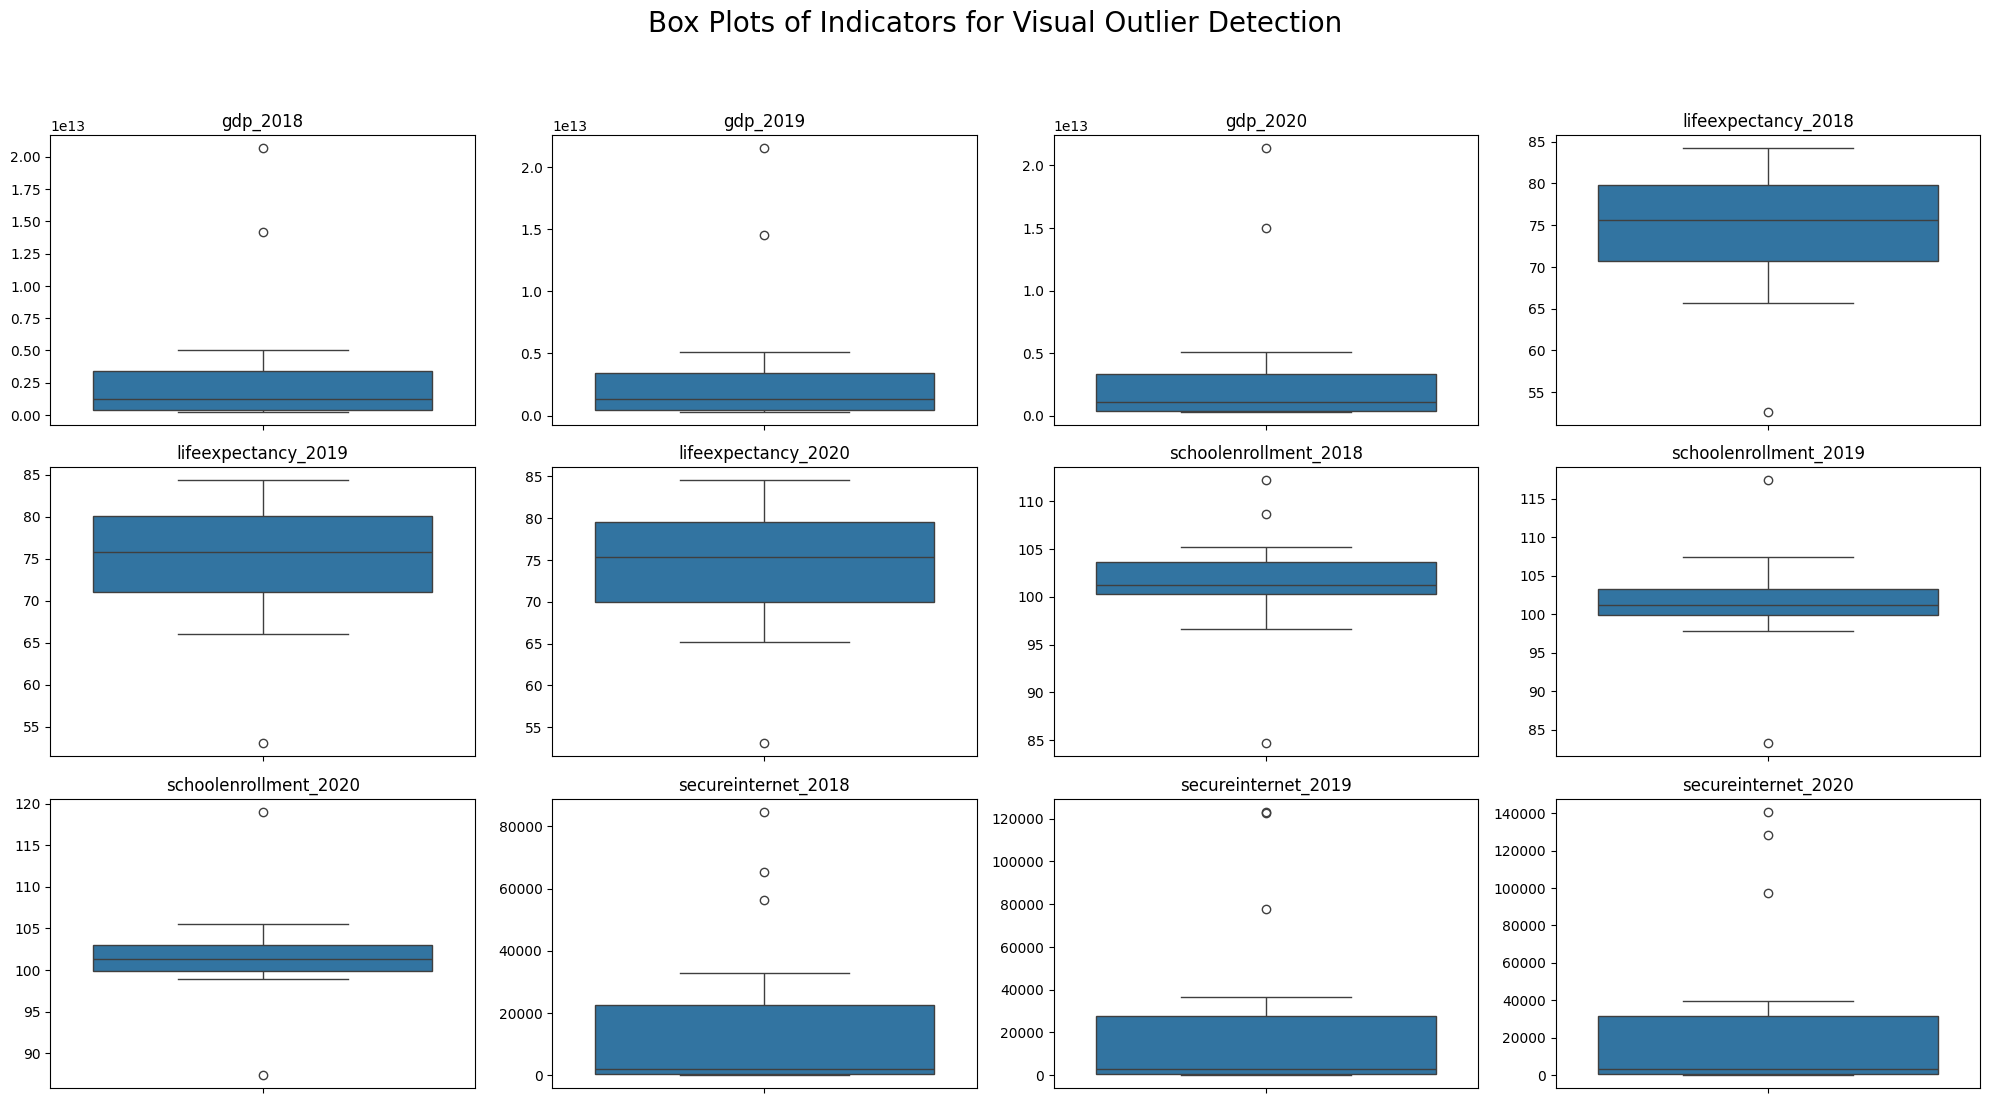

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# This code assumes your DataFrame is named 'df_analysis_ready'
# and is already loaded in your notebook's memory.

# --- Generate Box Plots ---
# Select only the numerical columns for plotting
numerical_cols = df_analysis_ready.select_dtypes(include=['number'])

# Set up the matplotlib figure
plt.figure(figsize=(20, 15))
plt.suptitle("Box Plots of Indicators for Visual Outlier Detection", fontsize=20)

# Loop through the numerical columns and create a box plot for each
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 4, i) # Adjust grid size if needed
    sns.boxplot(y=df_analysis_ready[col])
    plt.title(col)
    plt.ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

2. Z-Score Method (Statistical Method)

In [13]:
import numpy as np
from scipy.stats import zscore

# This code also assumes 'df_analysis_ready' exists in memory.

# --- Calculate Z-Scores and Find Outliers ---
# Select only the numerical columns for Z-score calculation
numerical_cols_for_zscore = df_analysis_ready.select_dtypes(include=np.number)

# Calculate the Z-scores for each column
z_scores = numerical_cols_for_zscore.apply(zscore)

# Define the threshold for identifying outliers
threshold = 3

# Find the positions of the outliers
outlier_positions = np.where(np.abs(z_scores) > threshold)

# --- Create a Report of the Outliers ---
print("\n--- Statistical Outlier Report (Z-Score > 3) ---")

# Create a DataFrame to store the outlier information
outlier_report = pd.DataFrame({
    'Row_Index': outlier_positions[0],
    'Column_Index': outlier_positions[1]
})

if not outlier_report.empty:
    # Get the names of the columns where outliers were found
    outlier_report['Column_Name'] = z_scores.columns[outlier_report['Column_Index']]
    # Get the outlier values from the original DataFrame
    outlier_report['Outlier_Value'] = [df_analysis_ready.iloc[row, col] for row, col in zip(outlier_positions[0], outlier_positions[1])]
    # Get the country information for context
    outlier_report['Country'] = df_analysis_ready.iloc[outlier_report['Row_Index']]['Country'].values

    # Reorder columns for a cleaner report
    outlier_report = outlier_report[['Country', 'Column_Name', 'Outlier_Value']]

    print("Potential outliers found:")
    print(outlier_report)
else:
    print("No significant outliers found with a Z-score threshold of 3.")


--- Statistical Outlier Report (Z-Score > 3) ---
Potential outliers found:
         Country Column_Name  Outlier_Value
0  United States    gdp_2019  United States


Data Standardisation using RobutsScaler

In [19]:
from sklearn.preprocessing import RobustScaler
import pandas as pd

# This code assumes your DataFrame 'df_analysis_ready' exists in your notebook's memory.

# --- 1. Isolate Numerical Data and Country Info ---
country_info = df_analysis_ready[['CountryCode', 'Country']]
numerical_data = df_analysis_ready.drop(columns=['CountryCode', 'Country'])

# --- ✨ FIX: Reset the index of the country_info DataFrame ---
# This ensures its index perfectly aligns with the new scaled DataFrame.
country_info.reset_index(drop=True, inplace=True)


# --- 2. Apply RobustScaler ---
# Initialize the scaler
scaler = RobustScaler()

# Fit the scaler and transform the numerical data
scaled_data = scaler.fit_transform(numerical_data)

# Convert the scaled data back to a DataFrame (this gets a new index: 0, 1, 2...)
df_scaled = pd.DataFrame(scaled_data, columns=numerical_data.columns)


# --- 3. Rejoin Country Info with Scaled Data ---
# Now that both have matching, clean indices, the join will be perfect.
df_ready_for_clustering = pd.concat([country_info, df_scaled], axis=1)

# --- 4. Final Safety Check and Save ---
# Add a final .dropna() to remove any rows that might have issues.
df_final_clean = df_ready_for_clustering.dropna()


# --- Display Final Result and Save to CSV ---
print("✅ Data has been successfully scaled and cleaned. No more missing values.")
print(f"Final dataset contains {len(df_final_clean)} rows.")
print("\n--- Sample of the Final DataFrame ---")
print(df_final_clean.head())



✅ Data has been successfully scaled and cleaned. No more missing values.
Final dataset contains 15 rows.

--- Sample of the Final DataFrame ---
  CountryCode           Country  gdp_2018  gdp_2019  gdp_2020  \
0         AUS         Australia  0.057865  0.029893  0.071512   
1         BRA            Brazil  0.222888  0.192000  0.122450   
2         CHN             China  4.349393  4.471626  4.785447   
3         DEU           Germany  0.943231  0.894963  0.972267   
4         EGY  Egypt, Arab Rep. -0.335264 -0.332411 -0.254268   

   lifeexpectancy_2018  lifeexpectancy_2019  lifeexpectancy_2020  \
0             0.784423             0.782607             0.817915   
1             0.000000             0.000000            -0.091763   
2             0.228852             0.235190             0.275812   
3             0.579812             0.605213             0.592061   
4            -0.513595            -0.507243            -0.585211   

   schoolenrollment_2018  schoolenrollment_2019  schoole

In [20]:
print(df_final_clean.isnull().sum())

CountryCode              0
Country                  0
gdp_2018                 0
gdp_2019                 0
gdp_2020                 0
lifeexpectancy_2018      0
lifeexpectancy_2019      0
lifeexpectancy_2020      0
schoolenrollment_2018    0
schoolenrollment_2019    0
schoolenrollment_2020    0
secureinternet_2018      0
secureinternet_2019      0
secureinternet_2020      0
dtype: int64


In [21]:
# This code assumes your final, scaled DataFrame is named 'df_ready_for_clustering'

# --- Save the ready-to-use DataFrame to a CSV file ---
file_name = 'Development_Indicators_Datamining.csv'
df_final_clean.to_csv(file_name, index=False)

print(f"✅ Your dataset is ready and has been saved as '{file_name}'.")


✅ Your dataset is ready and has been saved as 'Development_Indicators_Datamining.csv'.


In [22]:
import pandas as pd
df = pd.read_csv('Development_Indicators_Datamining.csv')
df

,CountryCode,Country,gdp_2018,gdp_2019,gdp_2020,lifeexpectancy_2018,lifeexpectancy_2019,lifeexpectancy_2020,schoolenrollment_2018,schoolenrollment_2019,schoolenrollment_2020,secureinternet_2018,secureinternet_2019,secureinternet_2020
0,AUS,Australia,0.057865,0.029893,0.071512,0.784423,0.782607,0.817915,-0.258658,-0.305802,-0.434632,1.398888,1.251435,1.198152
1,BRA,Brazil,0.222888,0.192000,0.122450,0.000000,0.000000,-0.091763,2.221209,1.779895,1.315312,0.000000,0.000000,0.000000
2,CHN,China,4.349393,4.471626,4.785447,0.228852,0.235190,0.275812,-0.930549,-0.874203,-0.708728,-0.073712,-0.075828,-0.071672
3,DEU,Germany,0.943231,0.894963,0.972267,0.579812,0.605213,0.592061,0.418755,0.373567,0.220547,2.463137,2.769224,3.079506
4,EGY,"Egypt, Arab Rep.",-0.335264,-0.332411,-0.254268,-0.513595,-0.507243,-0.585211,-1.409156,-0.995247,-0.748759,-0.092334,-0.101492,-0.101277
5,IDN,Indonesia,-0.072210,-0.062408,-0.021387,-0.612147,-0.602600,-0.687019,1.022670,0.387905,0.358530,-0.036150,-0.041109,-0.041641
6,IND,India,0.488072,0.516616,0.535883,-0.575217,-0.558784,-0.546916,-0.047823,-0.507137,0.000000,-0.085440,-0.088605,-0.087213
7,JPN,Japan,1.276862,1.286527,1.356447,0.945611,0.943338,0.960215,0.254285,0.403897,0.451963,0.434053,0.584132,0.642963
8,MEX,Mexico,0.000000,0.000000,0.000000,-0.146836,-0.141158,-0.516258,1.185453,1.110752,1.008766,-0.083451,-0.092563,-0.091912
9,NGA,Nigeria,-0.281569,-0.279843,-0.237582,-2.531485,-2.516350,-2.334463,-4.999335,-5.208360,-4.351856,-0.085836,-0.100063,-0.100297


In [23]:
print(df.isnull().sum())

CountryCode              0
Country                  0
gdp_2018                 0
gdp_2019                 0
gdp_2020                 0
lifeexpectancy_2018      0
lifeexpectancy_2019      0
lifeexpectancy_2020      0
schoolenrollment_2018    0
schoolenrollment_2019    0
schoolenrollment_2020    0
secureinternet_2018      0
secureinternet_2019      0
secureinternet_2020      0
dtype: int64


Trying out K-Means Clutering

Calculating inertia for different values of k...
Calculation complete.


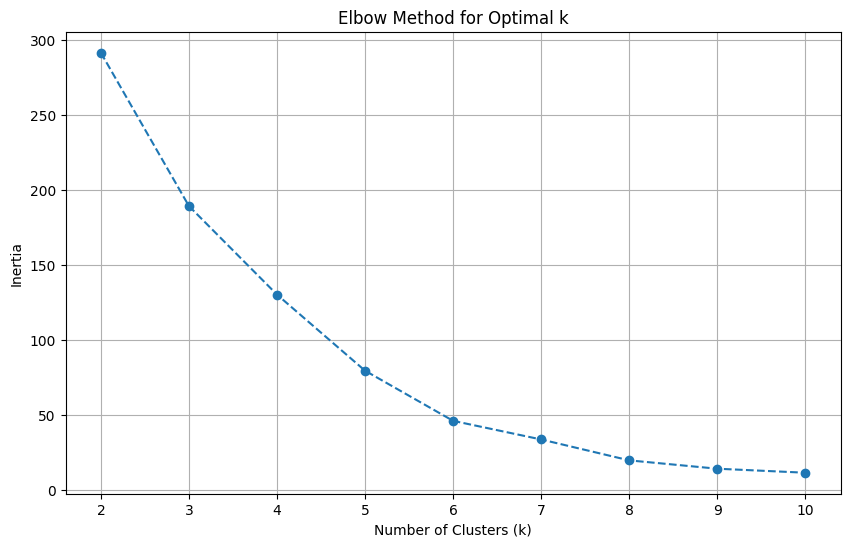

In [24]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

# This code assumes your final, clean, and scaled DataFrame is named 'df'.

# --- Prepare the data for clustering (remove non-numeric labels) ---
X = df.drop(columns=['CountryCode', 'Country'])

# --- Use the Elbow Method to find the optimal k ---
inertia = []
K_range = range(2, 11) # We will test k from 2 to 10 clusters

print("Calculating inertia for different values of k...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
print("Calculation complete.")

# --- Plot the Elbow Curve ---
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(K_range)
plt.grid(True)
plt.show()

Final Model Evaluation and Analyzing results with Optimal Cluster as K=4

In [25]:
# This code assumes your original DataFrame is named 'df' and the data for clustering is 'X'.

# --- Run the final K-means model with k=4 ---

OPTIMAL_K = 4 # Set based on your elbow plot result

print(f"Running K-means with {OPTIMAL_K} clusters...")
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
kmeans_final.fit(X)

# --- Add the cluster labels back to your original DataFrame ---
df['Cluster'] = kmeans_final.labels_

# --- Analyze the results ---
print(f"\n--- Countries Grouped into {OPTIMAL_K} Clusters ---")
# Display all countries from each cluster
for i in range(OPTIMAL_K):
    print(f"\n--- Cluster {i} ---")
    cluster_countries = df[df['Cluster'] == i]['Country'].values
    print(", ".join(cluster_countries))

# You can also view the full DataFrame with the new 'Cluster' column
print("\n\n--- DataFrame with Cluster Assignments ---")
print(df[['Country', 'Cluster']])

Running K-means with 4 clusters...

--- Countries Grouped into 4 Clusters ---

--- Cluster 0 ---
China, United States

--- Cluster 1 ---
Brazil, Egypt, Arab Rep., Indonesia, India, Japan, Mexico, Turkiye, Viet Nam, South Africa

--- Cluster 2 ---
Australia, Germany, Singapore

--- Cluster 3 ---
Nigeria


--- DataFrame with Cluster Assignments ---
             Country  Cluster
0          Australia        2
1             Brazil        1
2              China        0
3            Germany        2
4   Egypt, Arab Rep.        1
5          Indonesia        1
6              India        1
7              Japan        1
8             Mexico        1
9            Nigeria        3
10         Singapore        2
11           Turkiye        1
12     United States        0
13          Viet Nam        1
14      South Africa        1


 ###Cluster 0: The Economic Superpowers
This is the most straightforward cluster. The algorithm grouped the United States and China together because their GDP is orders of magnitude larger than any other country in your dataset. This massive economic output was the single most dominant feature for this group, setting them apart from all others.



### Cluster 2: The Advanced, High-Income Economies
This cluster contains Australia, Germany, and Singapore. These are all highly developed, high-income nations known for their excellent quality of life and technological infrastructure. The algorithm likely grouped them based on a combination of high life expectancy and a very high number of secure internet servers per capita, indicating their status as stable, advanced economies.



### Cluster 1: The Major Developing & Industrialized Nations
This is your largest and most diverse group. It includes major emerging economies (like India, Brazil, Indonesia, South Africa) alongside a highly developed nation, Japan. These countries represent the broad middle ground of the global economy. The algorithm likely grouped them because they share a profile of having substantial economies and populations but don't reach the extreme GDP of Cluster 0 or the consistent high-income metrics of Cluster 2.



Why is Japan here? While highly developed, Japan's profile across all 12 dimensions (4 indicators x 3 years) may align more closely with this group than with the smaller high-income countries in Cluster 2.



### Cluster 3: The Unique Developing Profile
This cluster contains only Nigeria. When a single data point forms its own cluster, it means its profile is unique compared to the others. Nigeria has a very large population and is a major African economy. However, its combination of development indicators (GDP, life expectancy, school enrollment, and internet infrastructure) is distinct enough from the large group in Cluster 1 and the other groups that the algorithm isolated it as its own category.

Visulazing the clusters

1. PCA Scatter Plot: How the Clusters are Separated

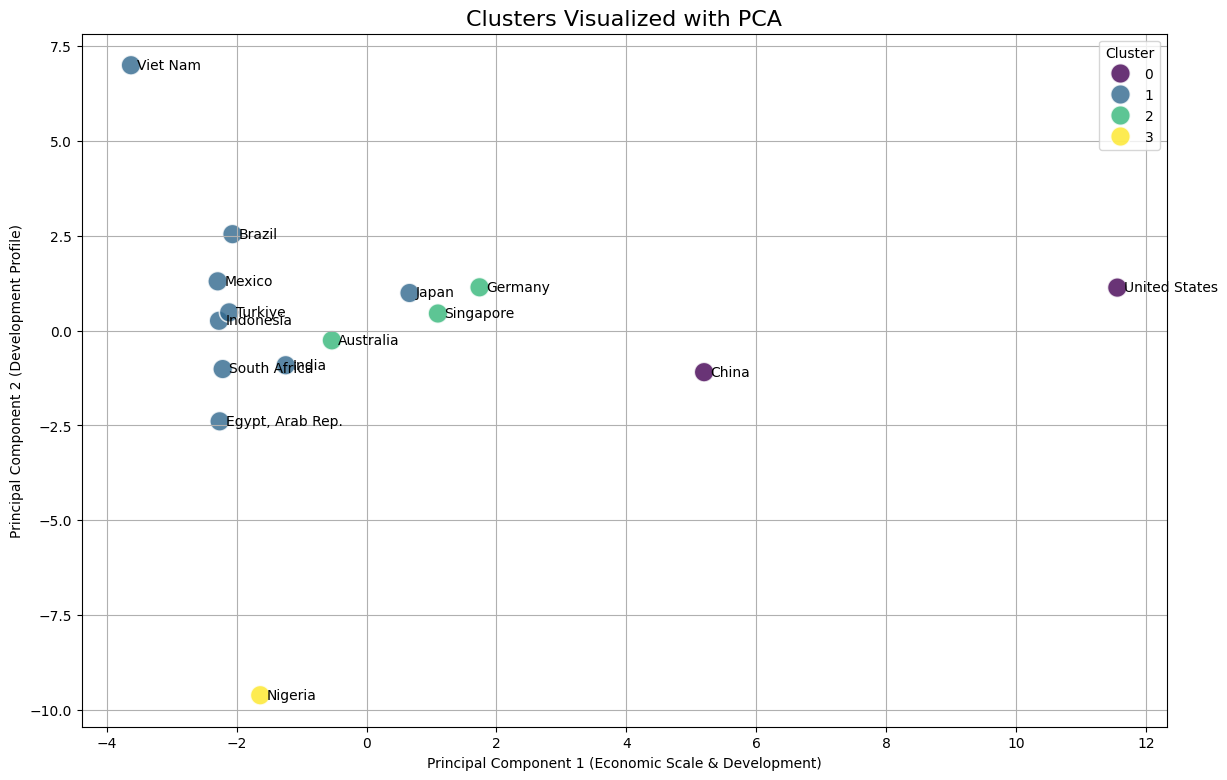

In [26]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# This code assumes your scaled data (without labels) is 'X'
# and your original DataFrame with cluster labels is 'df'.

# --- Perform PCA ---
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

# Create a new DataFrame with the PCA results
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = df['Cluster']
df_pca['Country'] = df['Country']


# --- Create the Scatter Plot ---
plt.figure(figsize=(14, 9))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='viridis', s=200, alpha=0.8)

# --- Add Country Names to the Plot ---
for i in range(df_pca.shape[0]):
    plt.text(x=df_pca.PC1[i]+0.1, y=df_pca.PC2[i]-0.1, s=df_pca.Country[i],
             fontdict=dict(color='black', size=10))

plt.title('Clusters Visualized with PCA', fontsize=16)
plt.xlabel('Principal Component 1 (Economic Scale & Development)')
plt.ylabel('Principal Component 2 (Development Profile)')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

2. Heatmap: A Single View of All Clusters

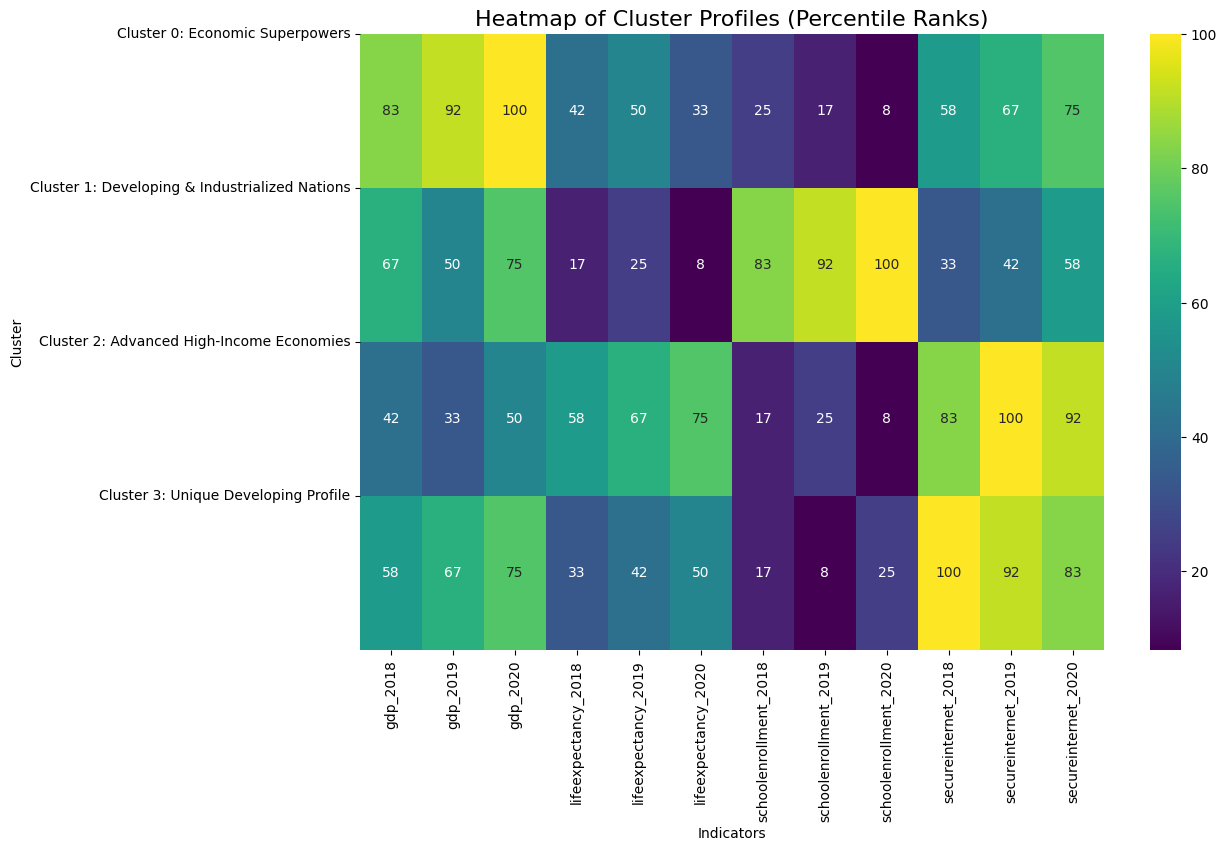

In [29]:
# Calculate the mean of each feature for each cluster
cluster_profiles = df.groupby('Cluster')[X.columns].mean()

# Calculate the percentile rank of each value within its indicator column
# We transpose the dataframe to apply rank over columns (indicators), then transpose back
profile_percentiles = cluster_profiles.rank(axis=1, pct=True) * 100

# Define cluster names for better interpretability
cluster_names = {
    0: 'Cluster 0: Economic Superpowers',
    1: 'Cluster 1: Developing & Industrialized Nations',
    2: 'Cluster 2: Advanced High-Income Economies',
    3: 'Cluster 3: Unique Developing Profile'
}

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(profile_percentiles, annot=True, cmap='viridis', fmt='.0f')

plt.title('Heatmap of Cluster Profiles (Percentile Ranks)', size=16)
plt.ylabel('Cluster')
plt.yticks(ticks=range(len(cluster_names)), labels=[cluster_names[i] for i in sorted(cluster_names)], rotation=0)
plt.xlabel('Indicators')
plt.show()

3. Bar Charts: A Clear Profile for Each Cluster

/tmp/ipython-input-2802185050.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis_ready['Cluster'] = df['Cluster']
/tmp/ipython-input-2802185050.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_data.index, y=cluster_data.values, ax=ax, palette='viridis')
/tmp/ipython-input-2802185050.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_data.index, y=cluster_data.values, ax=ax, palette='viridis')
/tmp/ipython-input

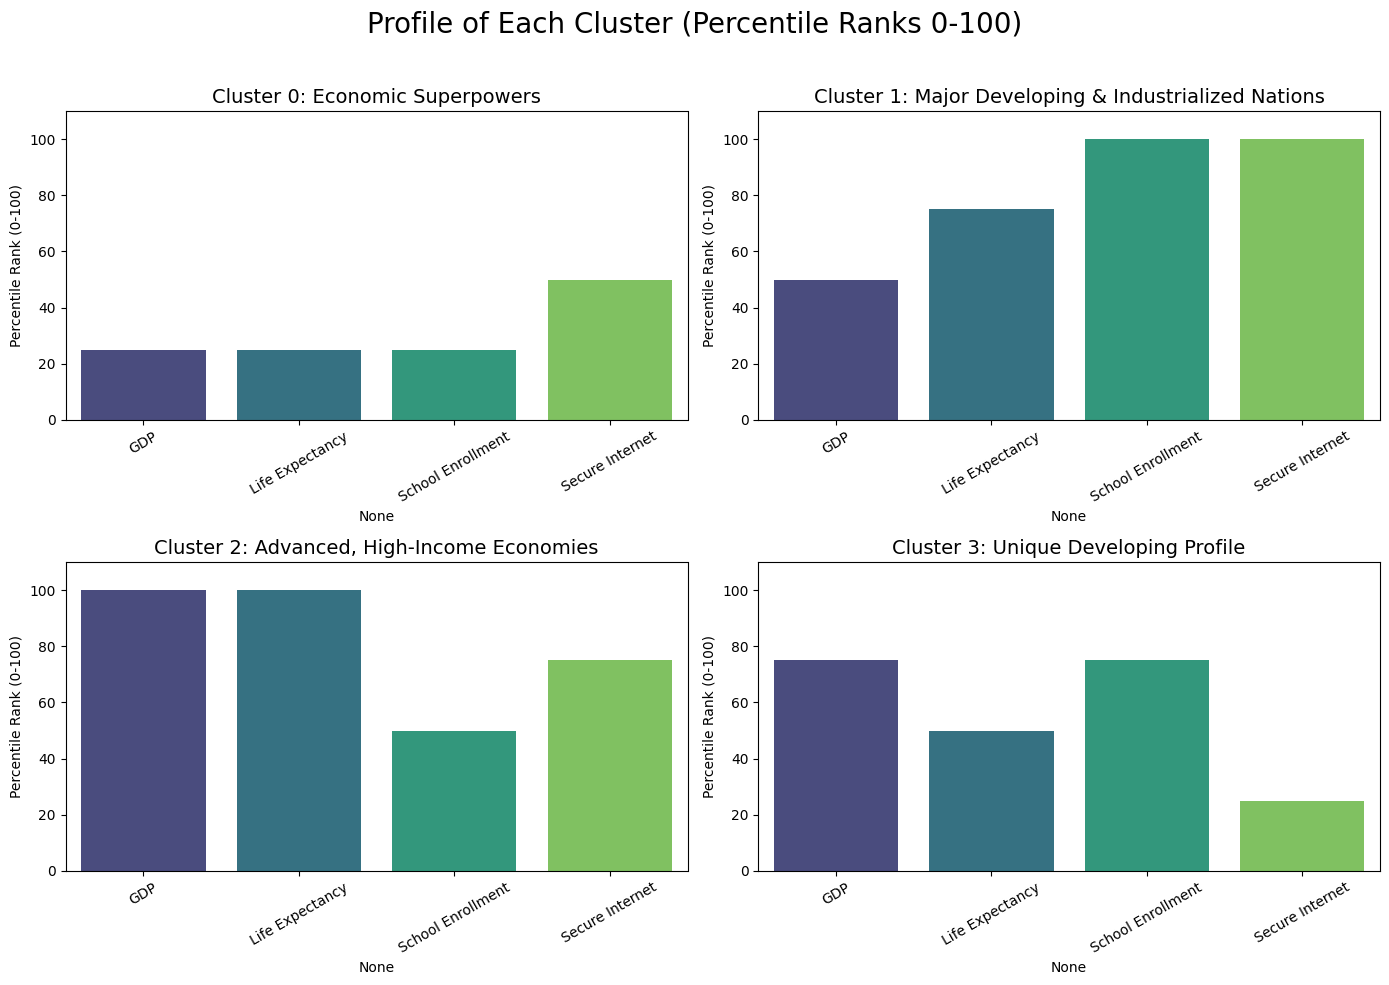

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import percentileofscore

# This code assumes your original DataFrame (before scaling) is 'df_analysis_ready'
# and your final DataFrame with cluster labels is 'df'.

# --- 1. Calculate Average Profiles and Convert to Percentiles ---
# (This part is the same as the radar chart code)
df_analysis_ready['Cluster'] = df['Cluster']
indicator_means = pd.DataFrame({
    'GDP': df_analysis_ready[['gdp_2018', 'gdp_2019', 'gdp_2020']].mean(axis=1),
    'Life Expectancy': df_analysis_ready[['lifeexpectancy_2018', 'lifeexpectancy_2019', 'lifeexpectancy_2020']].mean(axis=1),
    'School Enrollment': df_analysis_ready[['schoolenrollment_2018', 'schoolenrollment_2019', 'schoolenrollment_2020']].mean(axis=1),
    'Secure Internet': df_analysis_ready[['secureinternet_2018', 'secureinternet_2019', 'secureinternet_2020']].mean(axis=1),
    'Cluster': df_analysis_ready['Cluster']
})
cluster_avg_profiles = indicator_means.groupby('Cluster').mean()
profile_percentiles = cluster_avg_profiles.copy()
for col in profile_percentiles.columns:
    profile_percentiles[col] = [percentileofscore(cluster_avg_profiles[col], val) for val in cluster_avg_profiles[col]]


# --- 2. Plot Individual Bar Charts ---
fig, axs = plt.subplots(figsize=(14, 10), nrows=2, ncols=2)
fig.suptitle('Profile of Each Cluster (Percentile Ranks 0-100)', size=20)

cluster_names = {
    0: 'Cluster 0: Economic Superpowers',
    1: 'Cluster 1: Major Developing & Industrialized Nations',
    2: 'Cluster 2: Advanced, High-Income Economies',
    3: 'Cluster 3: Unique Developing Profile'
}

# Loop through each cluster and plot on its own subplot
for i, ax in enumerate(axs.flat):
    if i < len(profile_percentiles):
        cluster_data = profile_percentiles.iloc[i]
        sns.barplot(x=cluster_data.index, y=cluster_data.values, ax=ax, palette='viridis')
        ax.set_title(cluster_names.get(i, f'Cluster {i}'), size=14)
        ax.set_ylabel('Percentile Rank (0-100)')
        ax.set_ylim(0, 110) # Set y-axis limit to 110 for better readability
        ax.tick_params(axis='x', rotation=30) # Rotate x-axis labels

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()